# Importation

In [7]:
import cv2
import numpy as np
import os
import time
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import sys
import re
import fitz
from nltk import download
import pandas as pd
from tqdm import tqdm
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import pos_tag, RegexpParser, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyLDAvis
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk

# Download NLTK resources
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')

from PyPDF2 import PdfReader
from PIL import ImageGrab, Image
import fitz
import pytesseract
from pdf2image import convert_from_path
import pyautogui

# This Python environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here are several helpful packages to load in
import easyocr
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g., pd.read_csv)
import re
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hamma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\hamma\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [9]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\hamma\AppData\Local\Tesseract-OCR\tesseract.exe'

# Transforming to pictures

In [2]:
# PDF file paths
pdfPMBOK = "PMBOK6-2017.pdf" #431-494
pdfPMI = "practice-standard-project-risk-management.pdf" #1-116
output_folder_1="PMBOOKimgs"
output_folder_2="PMIimgs"

In [42]:
def convert_pdf_to_images(pdf_file_path, output_folder, start_page, end_page):
    images = convert_from_path(pdf_file_path, output_folder=output_folder, fmt='png', first_page=start_page, last_page=end_page, output_file="page")

    print("Done.")

In [43]:
convert_pdf_to_images(pdfPMBOK, output_folder_1, 431, 494)

Done.


In [44]:
convert_pdf_to_images(pdfPMI, output_folder_2, 1, 116)

Done.


# Extracting Figures

### YOLO: (does not work reason= bad results)

###### must install yolov3.weights yolov3.cfg coco.names (ask chatgpt)

In [80]:
import cv2
import numpy as np

# Load YOLO
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

# Load class names
with open("coco.names", "r") as f:
    classes = f.read().strip().split("\n")

# Load image
img = cv2.imread("PMIimgs/page0001-446.png")
height, width, channels = img.shape

# Perform object detection
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(net.getUnconnectedOutLayersNames())

# Information to store detected objects
class_ids = []
confidences = []
boxes = []

# Minimum confidence threshold
conf_threshold = 0.5

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > conf_threshold:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Non-maximum suppression to remove overlapping boxes
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Capture screenshots of detected objects
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        confidence = confidences[i]

        # Draw bounding box and label on the image
        color = (0, 255, 0)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Crop the object and save it as a screenshot
        object_roi = img[y:y + h, x:x + w]
        cv2.imwrite(f"{label}.png", object_roi)

# Scale factor for display
scale_factor = 0.3  # Adjust this value as needed

# Resize the image
resized_img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor)

# Display the resized image with bounding boxes
cv2.imshow("Image", resized_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [103]:
yolo_object_detection("PMBOOKimgs/page0001-432.png")

NameError: name 'yolo_object_detection' is not defined

### openCV:

In [3]:
def detect_shapes(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread("PMIimgs/"+image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    k=0
    for contour in contours:
        k=k+1
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Define a region of interest (ROI) using the rectangle coordinates
                roi = image[y:y+h, x:x+w]

                # Save the ROI as an image for inspection
                cv2.imwrite("screenshotsPMI/"+image_path+"/"+str(k)+"detected__"+image_path, roi)                
                

In [123]:
detect_shapes("page0001-445.png")

In [4]:
for k in os.listdir("PMIimgs/"):
    os.makedirs("screenshotsPMI/"+k, exist_ok=True)
    detect_shapes(k)

# Extracting Texts from images

### Using Pytesseract from imgs:

###### either extracts everything or extract without figures but wrong

In [41]:
def extract_text(image_path):
    # Read the image
    image = cv2.imread(image_path)
    

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Use adaptive thresholding to segment text from the background
    _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove horizontal and vertical lines using morphological operations
    kernel = np.ones((4, 4), np.uint8)
    clean_image = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    text = pytesseract.image_to_string(Image.fromarray(threshold))


    print(text)
    # Save the extracted text to a file
    #with open(output_text_path, 'w', encoding='utf-8') as text_file:
        #text_file.write(text)

In [44]:
extract_text("screenshotsPMI/page0001-446.png/54detected__page0001-446.png")

Project
Management
Plan

Project management plan

« Requirements management plan
« Schedule management plan
« Cost management plan

« Resource management plan
* Quality management plan
« Risk management plan
« Scope baseline

* Schedule baseline

* Cost baseline

Project
Documents

reject documents
Assumption log
Cost estimates 11.2

Issue log Risks
Lessons learned register

Project
eceeeseserseseeseneces: Docurnents

Risk register
* Risk report

Requirements documentation
Resource requirements.
Stakeholder register

Pr
.
.
* Duration estimates Identify
.
.
.
.
.

12.1
Plan
Procurement
Management

Procurement documentation

12.2
Conduct
Procurements

Agreements

Enterprise/
Organization

Enterprise environmental factors.
Organizational process assets

Project documents updates
« Assumption log

* Issue log

« Lessons learned register




###### either extracts everything or extract without figures but wrong

# Extracting Texts from pdf

#### Fitz

##### extracting titles 

In [558]:
import fitz  # PyMuPDF
import re
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Charger le modèle BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

def extract_titles_and_descriptions_from_pdf(pdf_file):
    pdf_document = fitz.open(pdf_file)
    titles_with_descriptions = []

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        page_text=page_text.replace('—','\n')

        # Utilisez une expression régulière pour rechercher des motifs de titre "11.x" ou "11.x.x" ou "11.x.x.x"
        matches = re.findall(r'(11+(\.\d+)+)\s+(.+)', page_text)
        for match in matches:
            title = match[0]
            description = match[2]

            # Prédire la partie manquante de la description en utilisant BERT
            masked_text = f"[MASK] {description}"
            input_ids = tokenizer.encode(masked_text, add_special_tokens=True, return_tensors="pt")
            mask_index = input_ids[0].tolist().index(tokenizer.mask_token_id)

            with torch.no_grad():
                predictions = model(input_ids)
            predicted_token_id = torch.argmax(predictions.logits[0, mask_index]).item()
            predicted_word = tokenizer.decode(predicted_token_id)

            # Remplacez le masque par le mot prédit dans la description
            description = description.replace("[MASK]", predicted_word)

            # Ajoutez le titre et la description complète à la liste
            titles_with_descriptions.append(f"{title} {description}")

    pdf_document.close()
    return titles_with_descriptions

# Exemple d'utilisation
pdf_file_path = 'PMBOK6-2017.pdf'
titles_with_descriptions = extract_titles_and_descriptions_from_pdf(pdf_file_path)

# Imprimez les titres avec les descriptions complètes
for title_with_description in titles_with_descriptions:
    print(title_with_description)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


11.1 Plan Risk Management ..............................................................................................401
11.1.1 Plan Risk Management: Inputs ......................................................................402
11.1.2 Plan Risk Management: Tools and Techniques .............................................404
11.1.3 Plan Risk Management: Outputs ...................................................................405
11.2 Identify Risks ..............................................................................................................409
11.2.1 Identify Risks: Inputs .....................................................................................411
11.2.2 Identify Risks: Tools and Techniques ............................................................414
11.2.3 Identify Risks: Outputs ...................................................................................417
11.3 Perform Qualitative Risk Analysis .........................................

##### =>>>>>>>>bad result

##### extracting Texts 

##### =>>>>>>>>bad result

In [559]:
import fitz  # PyMuPDF
import re
import pandas as pd  # Import Pandas
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Charger le modèle BERT
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForMaskedLM.from_pretrained(model_name)

def extract_concepts_and_definitions_from_pdf(pdf_file):
    pdf_document = fitz.open(pdf_file)
    concepts_and_definitions = []
    current_concept = ""
    current_definition = ""

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        page_text = page.get_text()
        page_text = page_text.replace('—', '\n')

        # Split the page text into lines
        lines = page_text.split("\n")

        for line in lines:
            # Check if the line matches the pattern for a concept
            if re.match(r'(11+(\.\d+)+)\s+(.+)', line):
                if current_concept:
                    # Append the current concept and definition to the list as a tuple
                    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))
                
                # Split the line into concept and definition
                concept_match = re.match(r'(11+(\.\d+)+)\s+(.+)', line)
                current_concept = concept_match.group(1)
                current_concept_name = concept_match.group(3)
                current_definition = ""
            else:
                # If the line does not match the pattern, consider it part of the definition
                current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))
    pdf_document.close()

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Definition"])
    return df

# Example of usage
pdf_file_path = 'PMBOK6-2017.pdf'
df = extract_concepts_and_definitions_from_pdf(pdf_file_path)

# Print or process the DataFrame
df

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Number,Concept,Definition
0,11.1,Plan Risk Management ............................,
1,11.1.1,Plan Risk Management: Inputs ....................,
2,11.1.2,Plan Risk Management: Tools and Techniques ......,
3,11.1.3,Plan Risk Management: Outputs ...................,"\n\nNot For Distribution, Sale or Reproduction..."
4,11.2,Identify Risks ..................................,
...,...,...,...
154,11.7.3.1,WORK PERFORMANCE INFORMATION,\nDescribed in Section 4.5.1.3. Work performan...
155,11.7.3.2,CHANGE REQUESTS,\nDescribed in Section 4.3.3.4. The Monitor Ri...
156,11.7.3.3,PROJECT MANAGEMENT PLAN UPDATES,\nAny change to the project management plan go...
157,11.7.3.4,PROJECT DOCUMENTS UPDATES,\nProject documents that may be updated as a r...


##### =>>>>>>>>bad result

In [555]:
import fitz
import pandas as pd

def extract_plain_text_from_pdf(pdf_file_path):
    # Open the PDF file
    pdf_document = fitz.open(pdf_file_path)

    # Initialize an empty list to store the extracted data
    data = []

    for page_number in range(431, 495):
        page = pdf_document.load_page(page_number)
        text = page.get_text()
        blocks = text.split("\n")

        # Initialize variables to store the current title and description
        current_title = ""
        current_description = ""

        for block in blocks:
            block = block.strip()

            if "Figure" in block:
                continue
            elif block.isupper():
                # If a new title is found, add the previous title and description to the data list
                if current_title:
                    data.append({"title": current_title, "description": current_description})
                current_title = block
                current_description = ""
            elif block.istitle():
                # If a new title is found, add the previous title and description to the data list
                if current_title:
                    data.append({"title": current_title, "description": current_description})
                current_title = block
                current_description = ""
            elif block.startswith("- "):
                continue
            else:
                # Append the block to the current description
                current_description += block + "\n"

        # Add the last title and description to the data list
        if current_title:
            data.append({"title": current_title, "description": current_description})

    # Close the PDF document
    pdf_document.close()

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)

    return df


In [556]:
# Extract plain text and create DataFrame
df = extract_plain_text_from_pdf(pdfPMBOK)

In [557]:
df

,title,description
0,Part 1 - Guide,
1,.1 Inputs,.1 Project charter\n.2 Project management plan...
2,.2 Tools & Techniques,.1 Expert judgment\n.2 Data analysis\n
3,.3 Meetings,
4,.3 Outputs,.1 Risk management plan\n
...,...,...
476,11.7.3.3 PROJECT MANAGEMENT PLAN UPDATES,Any change to the project management plan goes...
477,Part 1 - Guide,
478,11.7.3.4 PROJECT DOCUMENTS UPDATES,Project documents that may be updated as a res...
479,11.7.3.5 ORGANIZATIONAL PROCESS ASSETS UPDATES,Organizational process assets that are updated...


In [14]:
df.to_excel("data.xlsx", index=False)

# Returning to extracting from imgs:

#### we thought about covering figures with black screen and reading the rest using EasyOCR & cv2

# deleting figures in  image

In [11]:
def detect_and_remove_rectangles(image_path, min_contour_area=1000):
    # Read the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask with the same size as the image, initialized to white
    mask = np.ones_like(image) * 255

    for contour in contours:
        # Calculate the contour area
        area = cv2.contourArea(contour)

        # If the contour area is greater than the minimum threshold
        if area >= min_contour_area:
            # Approximate the contour as a polygon
            epsilon = 0.04 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Check if the polygon has 4 vertices, indicating a rectangle
            if len(approx) == 4:
                # Get the bounding box coordinates of the rectangle
                x, y, w, h = cv2.boundingRect(contour)

                # Set the region corresponding to the rectangle to black in the mask
                mask[y:y+h, x:x+w] = 0

    # Use the mask to copy the non-rectangle parts of the image to a new image
    result = cv2.bitwise_and(image, mask)

    return result


# Get a list of all image files in the folder
image_files = [f for f in os.listdir(output_folder_2) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Specify the output folder
output_folder = "output_folder_PMBOOKimgs"

# Check if the output folder exists, and if not, create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each image in the folder
for image_file in image_files:
    # Construct the full path to the image file
    image_path = os.path.join(output_folder_2, image_file)

    # Call the detect_and_remove_rectangles function
    output_image = detect_and_remove_rectangles(image_path)

    # Define the output file path for each processed image
    output_file = os.path.join(output_folder, image_file)

    # Save the processed image to the output folder
    cv2.imwrite(output_file, output_image)

print("Processing completed. Processed images are saved in the '{}' folder.".format(output_folder))

Processing completed. Processed images are saved in the 'output_folder_PMBOOKimgs' folder.


# Using EasyOCR now to detect words:(DO NOT RUN)

# (DO NOT RUN)

# (DO NOT RUN)

# (DO NOT RUN)

In [13]:
# Initialize the EasyOCR reader with the desired languages
reader = easyocr.Reader(['en'])

# Specify the folder containing the images
folder_path = 'output_folder_PMBOOKimgs'

# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Sort the image files based on their names
image_files.sort()

# Define the image to be skipped
skip_image = 'page0001-432.png'

# Create a text file to store the OCR results
output_file = 'ocr_results_PMBOOKimgs.txt'

# Loop through each image file
with open(output_file, 'w', encoding='utf-8') as txt_file:
    for image_file in image_files:
        # Check if the current image file matches the one to be skipped
        if image_file == skip_image:
            print(f"Skipping {skip_image}")
            continue  # Skip this image and move to the next one

        # Construct the full path to the image
        image_path = os.path.join(folder_path, image_file)

        # Load the image and convert it to a NumPy array
        image = np.array(Image.open(image_path))

        # Perform OCR on the image
        results = reader.readtext(image)

        # Write the OCR results for the current image to the text file
        for (text, bounding_box, prob) in results:
            txt_file.write(f"{bounding_box}\n")

print(f"OCR results have been saved to {output_file}")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Skipping page0001-432.png
OCR results have been saved to ocr_results_PMBOOKimgs.txt


# Extracting texts from figures to text file:

# (DO NOT RUN)

# (DO NOT RUN)

In [46]:
def extract_text_from_blocks(image_folder, output_folder, zoom_factor=1.0, min_characters=5):
    # Iterate through the images in the folder
    for filename in os.listdir(image_folder):
        if filename.endswith(('.jpg', '.png', '.jpeg')):  # Adjust the file extensions as needed
            # Construct the full path to the image
            image_path = os.path.join(image_folder, filename)

            # Read the image
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Use adaptive thresholding to segment text from the background
            _, threshold = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

            # Find contours of the blocks
            contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Initialize a counter for generating unique filenames
            counter = 1

            for contour in contours:
                # Extract the region of interest (ROI) for each block
                x, y, w, h = cv2.boundingRect(contour)
                block_roi = image[y:y+h, x:x+w]

                # Apply the zoom factor to the block ROI
                if zoom_factor != 1.0:
                    block_roi = cv2.resize(block_roi, None, fx=zoom_factor, fy=zoom_factor)

                # Use Tesseract to extract text from the block ROI
                text = pytesseract.image_to_string(Image.fromarray(block_roi))

                # Check if the extracted text contains at least 5 characters
                if len(text.strip()) >= min_characters:
                    # Print the extracted text
                    print(text)

                    # Generate a unique filename based on the counter
                    output_file = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_{counter}.txt")

                    # Increment the counter
                    counter += 1

                    # Save the extracted text to a file
                    with open(output_file, 'w', encoding='utf-8') as text_file:
                        text_file.write(text)

# Example usage with a zoom factor of 2.0 and a minimum of 5 characters:
input_folder = 'PMBOOKimgs'
output_folder = 'output_figures'
extract_text_from_blocks(input_folder, output_folder, zoom_factor=2.0, min_characters=10)

KeyboardInterrupt: 

# now extracting data from textfile(used because easyocr is too heavy to compile each time) into a dataframe:

In [12]:
import re
import pandas as pd

def extract_concepts_and_definitions_from_text(text_file):
    with open(text_file, 'r', encoding='utf-8') as file:
        text = file.read()

    concepts_and_definitions = []
    current_concept = ""
    current_concept_name = ""
    current_definition = ""

    lines = text.split('\n')

    for line in lines:
        # Check if the line matches the pattern for a concept
        if re.match(r'(\d+(\.\d+)*)\s+(.+)', line):
            if current_concept:
                # Append the current concept and definition to the list as a tuple
                concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

            # Split the line into concept and definition
            concept_match = re.match(r'(\d+(\.\d+)*)\s+(.+)', line)
            current_concept = concept_match.group(1)
            current_concept_name = concept_match.group(3)
            current_definition = ""
        else:
            # If the line does not match the pattern, consider it part of the definition
            current_definition += "\n" + line

    # Append the last concept and definition to the list
    concepts_and_definitions.append((current_concept, current_concept_name, current_definition))

    # Create a DataFrame
    df = pd.DataFrame(concepts_and_definitions, columns=["Number", "Concept", "Definition"])
    return df

# Example of usage
text_file_path = 'extractedPMI.txt'  # Replace with the path to your text file
df = extract_concepts_and_definitions_from_text(text_file_path)

# Print or process the DataFrame
print(df)


      Number                                            Concept  \
0         14                                     Carpus Bouvard   
1         88  appropriate, seek the advice of a competent pr...   
2        1.3  Role of Project Risk Management in Project Man...   
3        1.4                      Good Risk Management Practice   
4        1.6                                         Conclusion   
..       ...                                                ...   
233     5.15                  Critical Chain Project Management   
234    6.1.1                                   Reserve Analysis   
235  1.6.1.2                                        Risk Audits   
236        3                                  Risk Reassessment   
237        4                                    Status Meetings   

                                            Definition  
0    \nNeon Square, Pannsivania 19073-9200 USA\nPho...  
1    \nin any given circumstances. Information and ...  
2                       

In [13]:
df

,Number,Concept,Definition
0,14,Carpus Bouvard,"\nNeon Square, Pannsivania 19073-9200 USA\nPho..."
1,88,"appropriate, seek the advice of a competent pr...",\nin any given circumstances. Information and ...
2,1.3,Role of Project Risk Management in Project Man...,
3,1.4,Good Risk Management Practice,\n15. Critical Success Factors for Project Ris...
4,1.6,Conclusion,\nCHAPTER 2 - PRINCIPLES AND CONCEPTS.\n24° In...
...,...,...,...
233,5.15,Critical Chain Project Management,\nAsimplectical chain network is shown in Figu...
234,6.1.1,Reserve Analysis,\n\n‘An analytical technique to determine the ...
235,1.6.1.2,Risk Audits,\nFisk audits are caried out in order to evalu...
236,3,Risk Reassessment,\n\n‘The objective of risk reassessment is to ...


# We've also tried the masking using Pytesseract :(fitz)

In [ ]:
# Path to the PDF file
pdf_file_path = 'extracted_pmi.pdf'

# Function to extract text from an image while trying to skip figures/tables
def extract_text_from_image(image, figure_bboxes):
    # Create a mask to exclude figure regions
    mask = image
    for bbox in figure_bboxes:
        x0, y0, x1, y1 = bbox
        mask.clear(x0, y0, x1, y1)  # Clear figure region

    # Convert the mask to a PIL Image for OCR
    mask_image = Image.frombytes("RGB", [mask.width, mask.height], mask.samples)

    # Perform OCR on the masked image to extract text
    extracted_text = pytesseract.image_to_string(mask_image)

    return extracted_text

# Initialize PyMuPDF document
pdf_document = fitz.open(pdf_file_path)

# Process each page and extract text
for page_num in range(len(pdf_document)):
    # Get page from PyMuPDF document
    page = pdf_document[page_num]

    # Use PyMuPDF to get the bounding boxes of figures/tables
    figure_bboxes = []  # You may need to customize this part

    # Extract text from the image while trying to skip figures/tables
    page_image = page.get_pixmap()
    extracted_text = extract_text_from_image(page_image, figure_bboxes)
    
            txt_file.write(f"{bounding_box}\n")

In [11]:
from PIL import Image
import pytesseract
import fitz

# Path to the PDF file
pdf_file_path = 'extracted_pmi.pdf'
output_file_path = 'extractedPMI.txt'  # New file for saving extracted text

# Function to extract text from an image while trying to skip figures/tables
def extract_text_from_image(image, figure_bboxes):
    # Create a mask to exclude figure regions
    mask = image
    for bbox in figure_bboxes:
        x0, y0, x1, y1 = bbox
        mask.clear(x0, y0, x1, y1)  # Clear figure region

    # Convert the mask to a PIL Image for OCR
    mask_image = Image.frombytes("RGB", [mask.width, mask.height], mask.samples)

    # Perform OCR on the masked image to extract text
    extracted_text = pytesseract.image_to_string(mask_image)

    return extracted_text

# Initialize PyMuPDF document
pdf_document = fitz.open(pdf_file_path)

# Open file in write mode to save extracted text
with open(output_file_path, 'w', encoding='utf-8') as output_file:
    # Process each page and extract text
    for page_num in range(len(pdf_document)):
        # Get page from PyMuPDF document
        page = pdf_document[page_num]

        # Use PyMuPDF to get the bounding boxes of figures/tables
        figure_bboxes = []  # You may need to customize this part

        # Extract text from the image while trying to skip figures/tables
        page_image = page.get_pixmap()
        extracted_text = extract_text_from_image(page_image, figure_bboxes)

        # Write the extracted text to the output file
        output_file.write(extracted_text + '\n')

# Close the PyMuPDF document
pdf_document.close()

print(f"Extracted text saved to {output_file_path}")


Extracted text saved to extractedPMI.txt


# Cleaning Data and Normalization:

In [14]:
def clean_text(text):
    # Remove special characters and symbols (retain letters, numbers, and basic punctuation)
    cleaned_text = re.sub(r'[^a-zA-Z0-9.,!? ]', '', text)
    
    # Remove extra spaces and trim leading/trailing spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text.lower()

#  Tokenization :

In [15]:
from nltk.tokenize import word_tokenize
def tokenize(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    return tokens

#  POS-TAGGING

In [16]:
def pos_tagging(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tag(words)

    return pos_tags

#  STOPWORDS

In [17]:
def remove_stopwords_from_list(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS',",",".","!","?"]  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

#  Chunking :

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
def chunk_words_by_meaning(text):
    # Tokenize the text into words
    words = tokenize(text)

    # Perform POS tagging
    pos_tags = pos_tagging(text)
    chunks = []
    # Define a grammar for chunking (NP: Noun Phrase)
    # Define a grammar for chunking
    grammar = r"""
        NP: {<JJ.*>*<PRP|NN.*>+}   # chunk determiners, adjectives, personal pronouns, and nouns
        VP: {<MD>*<VB.*>+}      # chunk verb phrases with optional NP
        CHUNK: {<NP><VP>+<NP>}  # chunk relation with NP-VP-NP pattern
    """
    
    # Create a chunk parser with the defined grammar
    
    chunk_parser = RegexpParser(grammar)

    
    # Apply chunking to POS-tagged words
    tree = chunk_parser.parse(pos_tags)

        # Extract phrases from the tree
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK':
            listt=[]
            for sub in subtree:
                NP = ' '.join([token for token, _ in sub.leaves()])
                listt.append(NP)
            chunks.append(listt)
    print(chunks)

    return chunks,tree


#### after this phase it should be returned a list of chunks cleaned

#  Relationship & Concepts :(do not compile)

In [19]:
new = new.drop(new.index)

NameError: name 'new' is not defined

In [20]:
new=pd.DataFrame(columns=["Title","Description","Subject","Relation","Object"])

In [21]:
new

,Title,Description,Subject,Relation,Object


In [22]:
for index, row in df.iterrows():
    text = row["Definition"]
    cleaned_text = remove_stopwords_from_list(clean_text(text))
    chunks,tree = chunk_words_by_meaning(cleaned_text)
    for k in chunks:
        new.at[index, 'Title'] = row["Concept"]
        new.at[index, 'Description'] = row["Definition"]
        new.at[index, 'Subject']=k[0]
        new.at[index, 'Relation']=k[1]
        new.at[index, 'Object']=k[2]

[['ad th pmtoday logo', 'restored', 'mars'], ['cetct he', 'pmi', 'logal departmentpm fubcaons'], ['coectons commants', 'is', 'books'], ['a.copy relrant page tha bookmark he', 'ea', 'send io book et'], ['part work', 'may be', 'rproduod ar rans'], ['re writenermistio he', 'publi.the', 'paper'], ['wih parmanent paper sanda', 'issued', 'ha national norton standardsorganization'], ['volunteers', 'andor seeks', 'views persons'], ['interest inthe', 'topiccovered', 'publication pmi administers'], ['establishes rules', 'promate', 'fainess inthe development consensus'], ['it', 'does write document', 'it'], ['accuracy completeness information soundness judgments', 'contained', 'itsstandards'], ['guideline publicationsml', 'scaims', 'personal injury'], ['pmi', 'disclaims makes', 'quaranty waranty'], ['completeness information', 'published', 'herein'], ['individual manufacturer sellers products services', 'byvirtue', 'tis standard guide.in publishing'], ['professional otherservices', 'foror', 'beha

[['critical success factors', 'project', 'risk managementg2i08'], ['maapemantspecitic criteria success project risk management process ae', 'listed', 'inthe chapters'], ['general criteria success', 'includerecognize', 'value fisk managementproject risk management']]
[['project stakeholders', 'goth', 'intemal exlema'], ['individual commitment responsiiityproject participants stakeholders', 'should acceptesponsibility undertaking', 'riskrlated activities'], ['communicationeveryone shouldbe', 'involved', 'te project risk managementprocess'], ['organizational commitmentorganzational commitment', 'can be established', 'riskmanagement'], ['other project management disciplines', 'becausehandling', 'ofthe risks'], ['others levels', 'theproject', 'manager isk tort'], ['rsk management', 'activites', 'shouldbe consistent withthe valueofthe project'], ['projet risk management', 'should be', 'appropriate tits'], ['projet organization integration project managementproject risk management', 'does exi

[['defined steps project risk management describe', 'structured', 'approach'], ['chapter outines steps', 'required', 'effective projet risk'], ['step', 'is described', 'more detail subsequent chapters'], ['projet risk', 'isan', 'uncertain event condition tha'], ['clear risks', 'exist', 'relation toobjectives'], ['clear diferent projects', 'are exposed', 'diferent levels risk'], ['step intheproject risk management process shoul', 'be', 'scalable meet'], ['scalable elementsofthe process', 'include', 'available resources'], ['important tohave', 'dearunderstanding', 'isk thresholds'], ['asa framework', 'identified', 'risks'], ['asa result project rsk management process', 'start', 'ination step'], ['common understanding agreement ofthe team ater stakeholders', 'onthe', 'approachand parameters'], ['objectives', 'theproject', 'risk management process itself'], ['appropriate projec diferent projects', 'warrant', 'ctferent levels'], ['main actions', 'provide required', 'talring'], ['detine obje

[['risk', 'can be managed', 'i'], ['risk management', 'planing', 'hasbeen'], ['frst process iterative project risk management process', 'aims', 'identity theknowabl risks project objectives.iti'], ['level projectrisk exposure changes', 'asa', 'result decisions actions'], ['project ternal changeand', 'imposed', 'changethe purpose ofrskidentfication'], ['o identity risks', 'tothe', 'maximum extent'], ['ldenttyrisks process', 'find', 'new risks'], ['potential responses', 'may be identified', 'atthe same time'], ['risks process', 'considered', 'immediate actin'], ['such action i', 'appropriatewhere', 'such responses']]
[['practices', 'described', 'sections']]
[['fisk identification', 'should be performed', 'possible projec ifecycle'], ['uncertainty', 'is', 'high intial stages'], ['early risk identification', 'enables', 'key project decisions'], ['changes', 'tothe', 'project strategy'], ['enhances efficiency', 'responses taken', 'costly ones.gaiea pret agement ne']]
[['rsks', 'canbe identif

[['quantitative risk analysis process', 'provides', 'numerical estimate ofthe oeralletfect risk'], ['type analysis', 'can be used', 'evaluate lkenood success'], ['projectobjectives', 'estimate', 'contingency reserves'], ['time cost', 'are', 'appropiate risksand risk tolerance project stakeholders.itis'], ['uncertainty inthe projet', 'using', 'quantitative techniques'], ['simulation', 'may provide', 'mare realism estimate'], ['thatthe activity durations', 'lineitem', 'cost estimates'], ['aredeterministic howeveritshouldbe', 'recognized', 'quanttativeriskanalysisisnotalways'], ['qualitative risk analysis', 'may provide', 'enough information development ofeffective risk responses'], ['benefits', 'quantitative', 'risk analysis'], ['effort', 'required ensure', 'thattheadditional insights'], ['such qualitative isk analysis aim', 'prortizing', 'individual risks'], ['ata timeand', 'can produce', 'measures'], ['overall project risk risks', 'are considered simultaneously.calculating', 'estimates

[['decisionsupport tools', 'determining', 'optimal potential response strategy implementation techniques'], ['tools', 'transter', 'control tothe monitor contrl risks'], ['menagemantthese categories tools', 'can be used', 'identity'], ['risk responses', 'ae shown', 'figure response identificationfisk response planning'], ['available information potential risks', 'aims', 'determinethe'], ['i', 'should involve', 'subject matter experts'], ['project', 'planing', 'execution techniques'], ['selection process shouldake account', 'cst', 'ofthe responses'], ['uncertainty outcomes', 'andthe', 'possible secondary residualrisk'], ['plan', 'riskresponses', 'processes'], ['project management plan', 'andthe', 'residualand secondary risks it'], ['trative approach', 'continues', 'ofthe individual risks'], ['acceptable overal risks', 'predefined', 'threshold8.4.3'], ['action planningproject planning tools', 'are used', 'chosen strategies'], ['concrete actions', 'integrate intoexisting', 'plans'], ['acti

[['revisions', 'standard', 'possible improvements'], ['pace sada pret risk maapemantappendix ccontributors reviewers practice standardfor project risk', 'managementthis', 'appendix lists'], ['individuals', 'have contributed', 'theevelopment production practice standard project risk management'], ['simple ist evenrmulpe lists', 'can convey', 'contributions'], ['project management institute', 'is', 'grateful ofthese individuals'], ['acknowledgestheir contbutions', 'tothe', 'project management profession.g.1 practice standard project risk management project'], ['teamthe', 'following', 'individuals'], ['standards project', 'specialistnan', 'wolslayer'], ['significant contributorsin tothe members', 'project', 'core team subteam leaders'], ['ace sead fr pret i', 'meagan', 'arrenoiecc.3 practice standard project risk management team membersin addition'], ['individuals', 'participated', 'practice standard projectfisk management project'], ['teddy alton barnesgall', 'len', 'bartz david benflpau

[['technique', 'requires', 'tree steps1'], ['uistassumptions', 'constraints', 'forthe project2'], ['test assumptions constraints', 'asking', 'questionscould assumptionconsrant'], ['questions', 'are', 'answered yes'], ['constraint', 'may prove', 'fase'], ['results', 'can be documented', 'table form']]
[['standardules', 'brainstorming are modified', 'wien technique'], ['itis common structure risk identification brainstorm', 'using', 'risk categories'], ['structure.some evaluation', 'proposed', 'risks'], ['risk identification brainstorm', 'remove', 'nonisks'], ['active participation relevant stakeholders', 'risk', 'identification brainstorm'], ['templates examples', 'are presented', 'inthis append']]
[['technique presents', 'eiagrammatc', 'form causes'], ['use technique fr risk', 'dentficaton outcome', 'shouldbe stated2s eect ona project objective'], ['ofa sk diagram identifies', 'risks', 'uncertainevents'], ['technique forrisk', 'identicatio', 'distinguish risks'], ['example cause effect

[['techniques', 'fr', 'plan risk responses'], ['table ds sections', 'd.5.1.1', 'd.6.1.5technique strengths'], ['chapter planning ensuesthatacions', 'cangiveatase teeing', 'tigger conditionseavalbletoadess confidence'], ['ifthe ik', 'had been defined', 'accurence avoidedg2i08 pet agement'], ['efetivetechnique strengths weaknesses plicationows plans', 'need befocused', 'response'], ['pericalyimproves', 'mage', 'witingnes heprofessionals'], ['way wien he', 'execite', 'plan andprojets'], ['te budgetfd resouces', 'tigger', 'eontioncantogeny reserve'], ['avatonale poly fo reserveestimation', 'foresees', 'visible management agreedbasis forconstuctve'], ['bters', 'can requires', 'fulymanagement cpm approaches'], ['inadequate cater acreplanceshee', 'forspecialcases', 'bymanayementaektesse schedule'], ['andenddatscan members', 'theensngtufes', 'dtu conventional acy dates'], ['rate thanvaratonson', 'be', 'expectations'], ['darter ofroncatal', 'may cause being', 'general setpath activities'], ['pr

In [23]:
new.head(50)

,Title,Description,Subject,Relation,Object
0,Carpus Bouvard,"\nNeon Square, Pannsivania 19073-9200 USA\nPho...",anyone,using,dacument
1,"appropriate, seek the advice of a competent pr...",\nin any given circumstances. Information and ...,attributable pm,is,responsibilty certfer maker
3,Good Risk Management Practice,\n15. Critical Success Factors for Project Ris...,critical success factors,project,risk management
4,Conclusion,\nCHAPTER 2 - PRINCIPLES AND CONCEPTS.\n24° In...,chapter principles,concepts.24,introduction .22. definition project risk
9,Project Manager's Role for Project Risk Manage...,\nCHAPTER 3 - INTRODUCTION TO PROJECT RISK MAN...,critical success factors,forthe,plan risk management process
12,"Comply withthe Organization's Objectives, Poli...",\n43. Tools and Techniques for the Plan Risk M...,tools techniques,plan,risk management proces43.1
13,Documenting the Results of the Plan Risk Manag...,\n\n©2008 Fro apenas ate Sando fr Pact ak Mana...,procescritical success factors,identify,risks process
23,Objectivi,\n‘Tools and Techniques for the Identify Risks...,tools techniques,identify,risks
28,Purpose and Objectives of the Perform Qualitat...,\n62. Critical Success Factors for the Perform...,critical success factors,perform,qualitative risk analysis process .....
39,Purpose and Objectives of the Perform Quantita...,\n\n7.2. Critical Success Factors for the Perf...,critical success factors,perform,quantitative risk analysis process


#  Relationship & Concepts (different approach):

In [24]:
from collections import Counter  # Import the Counter class
def extrac_relations(chunked_text):
        # Extract and print identified concepts and relationships
    concepts = []
    relationships = []

    for subtree in chunked_text.subtrees():
        if subtree.label() == 'NP':
            concepts.append(" ".join(word for word, pos in subtree.leaves()))
        elif subtree.label() == 'VP':
            relationships.append(" ".join(word for word, pos in subtree.leaves()))

    # Concept frequencies
    concept_freq = Counter(concepts)
    frequency_threshold = 2  # Concepts that occur at least 10 times
    pertinent_concepts = [concept for concept in concepts if concept_freq[concept] >= frequency_threshold]

    print(f"Total Concepts: {len(concepts)}")
    print(f"Total Pertinent Concepts: {len(pertinent_concepts)}")
    print(f"Total Relationships: {len(relationships)}")
    print("================================================================")
    print("Concepts:", concepts)
    print("Relationships:", relationships)
    print("Pertinent Concepts :", pertinent_concepts)
    return pertinent_concepts

In [25]:
extrac_relations(tree)

Total Concepts: 10
Total Pertinent Concepts: 0
Total Relationships: 6
Concepts: ['risks', 'onthe agenda al project', 'typical agenda tems', 'top prot sks', 'changes', 'fisks', 'conditions', 'status ofthe actions', 'g2i08 pet agement', 'pace sada pret risk maapemant104']
Relationships: ['can shouldbe', 'reviews', 'should cover thefollowing', 'are', 'vigger', 'have occured']
Pertinent Concepts : []


[]

#  Lemmatization :

In [26]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization to the 'Subject' column
new['Subject'] = new['Subject'].apply(lemmatize_text)

In [27]:
# Apply lemmatization to the 'Subject' column
new['Object'] = new['Object'].apply(lemmatize_text)

In [28]:
new

,Title,Description,Subject,Relation,Object
0,Carpus Bouvard,"\nNeon Square, Pannsivania 19073-9200 USA\nPho...",anyone,using,dacument
1,"appropriate, seek the advice of a competent pr...",\nin any given circumstances. Information and ...,attributable pm,is,responsibilty certfer maker
3,Good Risk Management Practice,\n15. Critical Success Factors for Project Ris...,critical success factor,project,risk management
4,Conclusion,\nCHAPTER 2 - PRINCIPLES AND CONCEPTS.\n24° In...,chapter principle,concepts.24,introduction .22. definition project risk
9,Project Manager's Role for Project Risk Manage...,\nCHAPTER 3 - INTRODUCTION TO PROJECT RISK MAN...,critical success factor,forthe,plan risk management process
...,...,...,...,...,...
233,Critical Chain Project Management,\nAsimplectical chain network is shown in Figu...,valueanalysis canbe,compared,toquantitative riskanalysis result
234,Reserve Analysis,\n\n‘An analytical technique to determine the ...,necessary triggeringfurther risk management ac...,templates,example
235,Risk Audits,\nFisk audits are caried out in order to evalu...,risk management rule,adequate controling,project
236,Risk Reassessment,\n\n‘The objective of risk reassessment is to ...,objective risk reassessment,is ensure,tha ful risk management cycle i


#  Frequencies :

In [29]:
# Concatenate the two columns
concatenated_values = pd.concat([new['Subject'], new['Object']])

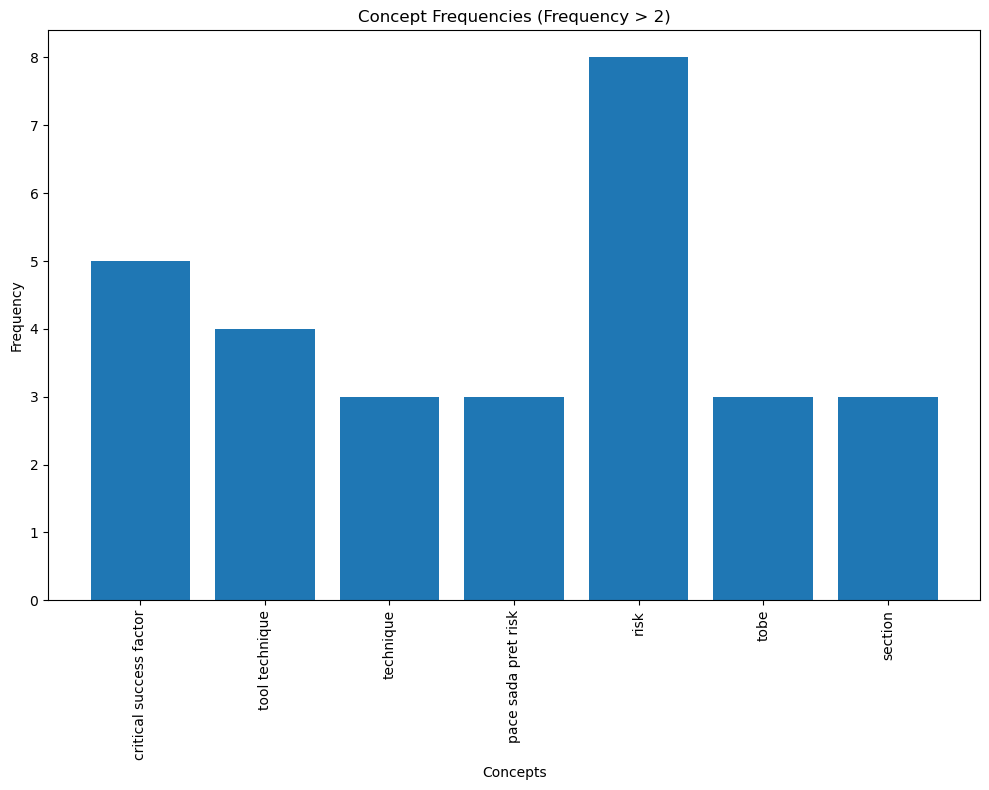

In [30]:
import matplotlib.pyplot as plt
from collections import Counter

# Your concatenated_values_reset Series
concept_freq = Counter(concatenated_values)

# Filter out concepts with frequency less than or equal to 2
filtered_concept_freq = {concept: freq for concept, freq in concept_freq.items() if freq > 2}

# Plot the filtered concept frequencies
plt.figure(figsize=(10, 8))
plt.bar(filtered_concept_freq.keys(), filtered_concept_freq.values())
plt.xlabel("Concepts")
plt.ylabel("Frequency")
plt.title("Concept Frequencies (Frequency > 2)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#  TF-IDF(Vectorization) :

TF(t, d) = (Number of times term t appears in document d) / (Total number of terms in document d)

IDF(t, D) = log((Total number of documents in corpus D) / (Number of documents containing term t) + 1)

TF-IDF(t, d, D) = TF(t, d) * IDF(t, D)


mini function to remove any useless words:    (adding points)

In [31]:
def remove_stopwords_from_list2(text):
    
    pos_tags=pos_tagging(text)
    word_list=tokenize(text)
    # Define a list of POS tags for words to keep (e.g., nouns and adjectives)
    allowed_pos_tags = ['VBD',  # Verb, past tense
        'VBG',  # Verb, gerund or present participle
        'VBN',  # Verb, past participle
        'VBP',  # Verb, non-3rd person singular present
        'VBZ',  # Verb, 3rd person singular present
        'PRP','NN','VB',"MD", 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS']  # Nouns and adjectives
    
    # Filter out stopwords based on POS tags
    filtered_words = [word for word, pos_tag in zip(word_list, pos_tags) if pos_tag[1]
                      in allowed_pos_tags]
    
    return ' '.join(filtered_words)

In [32]:
# Assuming 'new' is your DataFrame and 'Description' is the column
documents = new['Description'].tolist()
# Apply the clean_text function to each document
documents = [remove_stopwords_from_list2(clean_text(doc)) for doc in documents]

In [33]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(documents)

# Convert the TF-IDF matrix to a DataFrame
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Display the TF-IDF DataFrame
print(df_tfidf)

      14  2009   21        22  2208        24  272727  2or  2pe        32  \
0    0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
1    0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
2    0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
3    0.0   0.0  0.0  0.461944   0.0  0.426978     0.0  0.0  0.0  0.000000   
4    0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.239687   
..   ...   ...  ...       ...   ...       ...     ...  ...  ...       ...   
150  0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
151  0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
152  0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
153  0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   
154  0.0   0.0  0.0  0.000000   0.0  0.000000     0.0  0.0  0.0  0.000000   

     ...  yes  ypographicalformating  zafar  zaina  zakaria  zhousuresh  zm

#  Similarity:

In [34]:
def similarity(documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # Calculate cosine similarity
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Create a DataFrame for the similarity matrix
    df = pd.DataFrame(similarity_matrix, index=[f"Doc_{i}" for i in range(1, len(documents) + 1)], columns=[f"Doc_{i}" for i in range(1, len(documents) + 1)])
    
    return df

In [35]:
# Call the similarity function
similarity_matrix = similarity(documents)

# Now, similarity_matrix is a DataFrame containing the similarity matrix
print(similarity_matrix)

            Doc_1     Doc_2     Doc_3     Doc_4     Doc_5     Doc_6     Doc_7  \
Doc_1    1.000000  0.160365  0.017741  0.003198  0.034557  0.006812  0.003722   
Doc_2    0.160365  1.000000  0.040113  0.044752  0.074810  0.015035  0.000000   
Doc_3    0.017741  0.040113  1.000000  0.047021  0.498553  0.079924  0.129812   
Doc_4    0.003198  0.044752  0.047021  1.000000  0.197039  0.012385  0.000000   
Doc_5    0.034557  0.074810  0.498553  0.197039  1.000000  0.196911  0.063690   
...           ...       ...       ...       ...       ...       ...       ...   
Doc_151  0.023309  0.033456  0.074280  0.025031  0.078568  0.044176  0.038170   
Doc_152  0.033648  0.043093  0.084107  0.021572  0.137715  0.058600  0.022946   
Doc_153  0.039549  0.020999  0.102856  0.021782  0.163962  0.100222  0.000000   
Doc_154  0.023985  0.020629  0.072417  0.020957  0.130737  0.042958  0.010181   
Doc_155  0.007720  0.006991  0.024216  0.012375  0.036135  0.006378  0.015037   

            Doc_8     Doc_9

#  LDA:

In [36]:
# Create a dictionary and a corpus
id2word = corpora.Dictionary([doc.split() for doc in documents])
corpus = [id2word.doc2bow(doc.split()) for doc in documents]

# Set the number of topics
num_topics = 30  # Adjust as needed

# LDA Model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=num_topics,
                                   random_state=100,
                                   update_every=1,
                                   chunksize=100,
                                   passes=10,
                                   alpha='auto',
                                   per_word_topics=True)

# Display topics
print(lda_model.print_topics())

[(15, '0.000*"risk" + 0.000*"management" + 0.000*"project" + 0.000*"be" + 0.000*"should" + 0.000*"risks" + 0.000*"stakeholders" + 0.000*"process" + 0.000*"ofthe" + 0.000*"objectives"'), (0, '0.000*"management" + 0.000*"risk" + 0.000*"project" + 0.000*"plan" + 0.000*"be" + 0.000*"organization" + 0.000*"is" + 0.000*"pmi" + 0.000*"should" + 0.000*"processes"'), (12, '0.003*"managementprovides" + 0.003*"benefts" + 0.003*"organizationalcommitment" + 0.003*"performing" + 0.003*"manner.gaiea" + 0.003*"specifics" + 0.003*"appropriatelyapplied" + 0.003*"unbiased" + 0.003*"taking" + 0.003*"according"'), (22, '0.003*"done" + 0.003*"operating" + 0.003*"duringthe" + 0.003*"lie" + 0.003*"isrepeated" + 0.003*"pont" + 0.003*"determined" + 0.000*"project" + 0.000*"projector" + 0.000*"risk"'), (1, '0.000*"risk" + 0.000*"project" + 0.000*"analysis" + 0.000*"risks" + 0.000*"management" + 0.000*"be" + 0.000*"may" + 0.000*"process" + 0.000*"should" + 0.000*"quantitative"'), (7, '0.007*"nto" + 0.003*"identit

# Visualization of LDA

In [37]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

#  Identifying topics:

In [38]:
# Get the topics for each document
document_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Create a DataFrame to display topics for each document
df_topics = pd.DataFrame(index=range(1, len(documents) + 1))

# Iterate through the topics and populate the DataFrame
for i, topics in enumerate(document_topics, 1):
    topic_values = [topic[1] for topic in topics]
    df_topics[f'Doc_{i}'] = topic_values + [0] * (len(documents) - len(topic_values))

# Display the DataFrame with topics for each document
print(df_topics)

        Doc_1     Doc_2     Doc_3     Doc_4     Doc_5     Doc_6     Doc_7  \
1    0.857636  0.041960  0.010482  0.183755  0.139597  0.168741  0.290017   
2    0.115979  0.322162  0.607656  0.748793  0.791556  0.769788  0.081512   
3    0.000000  0.626346  0.310600  0.000000  0.049175  0.000000  0.597194   
4    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
151  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
152  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
153  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
154  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
155  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

        Doc_8     Doc_9    Doc_10  ...   Doc_146   Doc_147   Doc_148  \
1  

C:\Users\hamma\AppData\Local\Temp\ipykernel_14148\3628281588.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_topics[f'Doc_{i}'] = topic_values + [0] * (len(documents) - len(topic_values))
C:\Users\hamma\AppData\Local\Temp\ipykernel_14148\3628281588.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_topics[f'Doc_{i}'] = topic_values + [0] * (len(documents) - len(topic_values))
C:\Users\hamma\AppData\Local\Temp\ipykernel_14148\3628281588.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r